<a href="https://colab.research.google.com/github/EnochYounceSAIC/FiberOptics/blob/main/weektwo/chromatic_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
length = 3000
span = 100
lambda_light = 1550e-9
f_light = 3e8/lambda_light
#fiber data sheet used : https://www.corning.com/media/worldwide/coc/documents/Fiber/product-information-sheets/PI-1470-AEN.pdf
dispersion = 18 #ps/nm/km
distance = np.arange(0,length,1)


In [303]:
#This code is AI- assisted and is used for the generation of psuedorandom data to test the dispersion
def gen_random_data(type, amount):
  if type == '16qam':
    # 1. Generate random bits
    random_bits = np.random.randint(0, 2, 4*amount)

    # 2. Reshape into groups of 4 bits
    bit_groups = random_bits.reshape(-1, 4)

    # 3. Map 4-bit groups to 16-QAM constellation points
    # Define the 16-QAM constellation mapping
    qam16_mapping = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 0): -3 + 3j, (0, 0, 1, 1): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 0): -1 + 3j, (0, 1, 1, 1): -1 + 1j,
        (1, 0, 0, 0):  3 - 3j, (1, 0, 0, 1):  3 - 1j, (1, 0, 1, 0):  3 + 3j, (1, 0, 1, 1):  3 + 1j,
        (1, 1, 0, 0):  1 - 3j, (1, 1, 0, 1):  1 - 1j, (1, 1, 1, 0):  1 + 3j, (1, 1, 1, 1):  1 + 1j
    }

    qam16_symbols = np.array([qam16_mapping[tuple(group)] for group in bit_groups])
    return qam16_symbols
  elif type == 'qpsk':
    # 1. Generate random bits
    random_bits_qpsk = np.random.randint(0, 2, 2*amount)

    # 2. Reshape into groups of 2 bits
    bit_groups_qpsk = random_bits_qpsk.reshape(-1, 2)

    # 3. Map 2-bit groups to QPSK constellation points
    # Define the QPSK constellation mapping
    qpsk_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): -1 + 1j,
        (1, 0):  1 - 1j,
        (1, 1):  1 + 1j
    }

    qpsk_symbols = np.array([qpsk_mapping[tuple(group)] for group in bit_groups_qpsk])
    return qpsk_symbols
  elif type == 'bpsk':
    # 1. Generate random bits (0 or 1)
    random_bits_bpsk = np.random.randint(0, 2, amount)

    # 2. Map these bits to BPSK constellation points: 0 maps to -1, and 1 maps to 1.
    # This can be done by multiplying by 2 and subtracting 1: 0*2 - 1 = -1, 1*2 - 1 = 1
    bpsk_symbols = 2 * random_bits_bpsk - 1
    return bpsk_symbols
def apply_chromatic_dispersion(modulated_optical_signal, fiber_length_km, dispersion, lambda_light, time_step, freq_scaling_factor):
  """
  Applies chromatic dispersion to a modulated optical signal.

  Args:
    modulated_optical_signal: The time-domain modulated optical signal (NumPy array).
    fiber_length_km: The length of the fiber in kilometers.
    dispersion: The dispersion parameter of the fiber (in ps/nm/km).
    lambda_light: The operating wavelength (in meters).
    time_step: The time difference between samples of the signal (in seconds).
    freq_scaling_factor: The factor used to scale the baseband frequency axis
                         to represent the desired optical bandwidth in the GHz range.

  Returns:
    The time-domain dispersed optical signal (NumPy array).
  """

  # Calculate beta_2 from the dispersion parameter and wavelength
  # dispersion is in ps/nm/km, lambda_light is in meters
  # conversion: 1 ps/nm/km = 1e-6 s/m^2
  # beta_2 (s^2/m) = - lambda_light^2 / (2 * pi * c) * D (in s/m^2)
  c = 3e8 # Speed of light in m/s
  dispersion_s_per_m2 = dispersion * 1e-6
  beta_2 = -lambda_light**2 / (2 * np.pi * c) * dispersion_s_per_m2


  # 1. Perform FFT on the modulated optical signal.
  modulated_signal_freq = np.fft.fft(modulated_optical_signal)
  num_samples = len(modulated_optical_signal)

  # 2. Calculate the baseband frequency axis based on the signal length and time step.
  # Then scale it to represent the desired optical bandwidth.
  baseband_freq_axis = np.fft.fftfreq(num_samples, time_step)
  freq_axis_scaled = baseband_freq_axis * freq_scaling_factor


  # 3. Calculate the dispersion operator in the optical frequency domain.
  # Use the beta_2, fiber_length_km (converted to meters), and the scaled frequency axis.
  fiber_length_m = fiber_length_km * 1000 # Convert km to meters
  # H_D(f, L) = exp(j * 0.5 * beta_2 * (2 * pi * f_relative_to_carrier)^2 * L)
  # Use the scaled frequency axis as f_relative_to_carrier
  dispersion_operator_optical = np.exp(1j * 0.5 * beta_2 * (2 * np.pi * freq_axis_scaled)**2 * fiber_length_m)


  # 4. Apply the dispersion operator in the frequency domain (element-wise multiplication).
  dispersed_modulated_signal_freq = modulated_signal_freq * dispersion_operator_optical


  # 5. Perform IFFT to transform the dispersed optical signal back to the time domain.
  dispersed_optical_signal = np.fft.ifft(dispersed_modulated_signal_freq)

  return dispersed_optical_signal

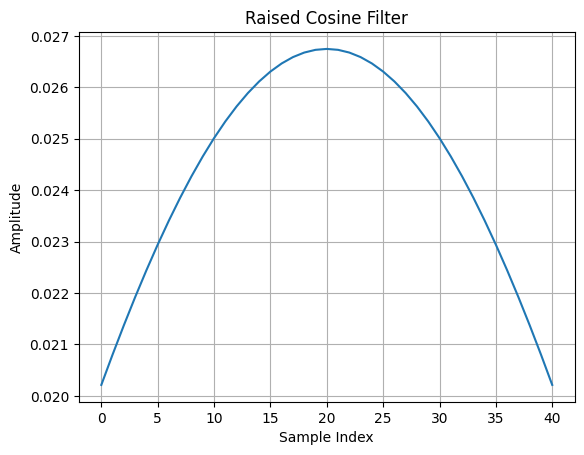

Symbol Rate: 10.0 Gbaud
Sampling Rate: 500.0 GSa/s
Time Step: 2.0 ps
Number of Symbols: 5000
Length of the shaped signal: 250040 samples
Total simulation time duration: 500.08 ns


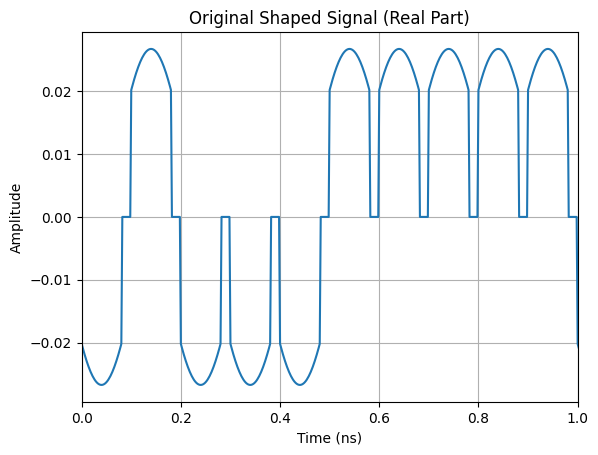

In [304]:
# Assuming a high symbol rate for realistic bandwidth simulation
# Let's use 10 Gbaud (10 symbols per nanosecond)
symbol_rate = 10e9 # 10 Gbaud = 10 * 10^9 symbols/second

# Amount of data (symbols) to generate - keep short for computational efficiency
amount = 5000 # 5000 symbols at 10 Gbaud = 500 ns total duration

# Samples per symbol - determines the sampling rate
sps = 50 # 50 samples per symbol

# Calculate sampling rate
sampling_rate = sps * symbol_rate # 50 samples/symbol * 10^10 symbols/sec = 500 * 10^9 samples/sec = 500 GSa/s

# Calculate time step
time_step = 1 / sampling_rate # 1 / (500 * 10^9) seconds = 2 * 10^-12 seconds = 2 ps


# Generate random data (symbols)
# 5000 should provide a longer signal for better observation of effects
data = gen_random_data('bpsk', amount) # Increased amount of data
#samples per signal at 50 for now
#sps = 50 # Already defined above


#RRC filter design
# fs here refers to samples per symbol, which is our sps
fs_rrc = sps
num_weights = 41
alpha = 0.1
# Adjust x axis for RRC filter design based on samples per symbol (sps)
x = 0.9999 * np.arange(-int(num_weights/2), int(num_weights/2)+1, 1) / fs_rrc
raised_cos_weights = np.sinc(x) * (np.cos(alpha * np.pi * x) / (1 - ((2 * alpha * x)**2)))

# Normalize the weights and graph
# The normalization factor should ensure the filter has unit energy or unit peak at t=0
# A simple normalization is dividing by the sum of weights, or based on desired peak/energy
# Let's normalize by the sum of weights for simplicity for now
raised_cos_weights /= np.sum(raised_cos_weights)


plt.figure() # Create a new figure for the plot
plt.plot(raised_cos_weights)
plt.title('Raised Cosine Filter')
plt.xlabel('Sample Index') # Label in terms of samples
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


#pulse shaping
# 1. Upsample the symbols by inserting zeros
# Length of upsampled signal = amount of symbols * sps
upsampled_symbols = np.zeros(amount * sps, dtype=complex)
upsampled_symbols[::sps] = data

# 2. Convolve the upsampled signal with the raised_cos_weights filter.
# The length of the convolved signal is len(upsampled_symbols) + len(raised_cos_weights) - 1
shaped_signal = np.convolve(upsampled_symbols, raised_cos_weights, mode='full')

# 3. Generate the time vector for the shaped signal
# The length of the time vector should match the length of the shaped signal
t = np.arange(0, len(shaped_signal)) * time_step


# 4. Print the length of the shaped signal and total time duration to confirm
print(f"Symbol Rate: {symbol_rate/1e9} Gbaud")
print(f"Sampling Rate: {sampling_rate/1e9} GSa/s")
print(f"Time Step: {time_step*1e12} ps")
print(f"Number of Symbols: {amount}")
print(f"Length of the shaped signal: {len(shaped_signal)} samples")
print(f"Total simulation time duration: {len(shaped_signal) * time_step * 1e9:.2f} ns")


# Optional: Plot the shaped signal (first few symbols)
plt.figure() # Create a new figure for the plot
plt.plot(t * 1e9, np.real(shaped_signal)) # Plot time in nanoseconds
plt.title('Original Shaped Signal (Real Part)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 10 * (1/symbol_rate) * 1e9) # Show first 10 symbol durations in nanoseconds
plt.show()

Text(0, 0.5, 'Amplitude')

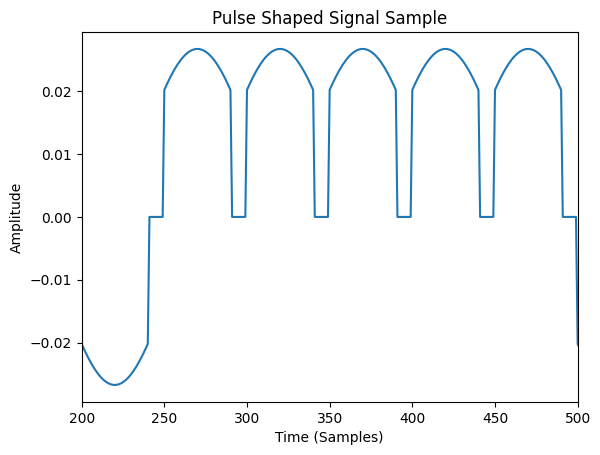

In [305]:
plt.plot(np.real(shaped_signal))
#arbitrary range to show a few pulses
plt.xlim(200,500)
plt.title('Pulse Shaped Signal Sample')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')

In [306]:

# Assuming symbol_rate = 1 for now as used in time_step calculation elsewhere
sampling_rate = sps # Samples per symbol * Symbol Rate (assuming Symbol Rate = 1)
time_step = 1 / sampling_rate # Time between samples
t = np.arange(0, len(shaped_signal)) * time_step
optical_carrier = np.cos(2 * np.pi * f_light * t)

modulated_signal = np.real(shaped_signal) * np.cos(2 * np.pi * f_light * t) - np.imag(shaped_signal) * np.sin(2 * np.pi * f_light * t)


print("Shaped signal modulated to 1550 nm.")

Shaped signal modulated to 1550 nm.


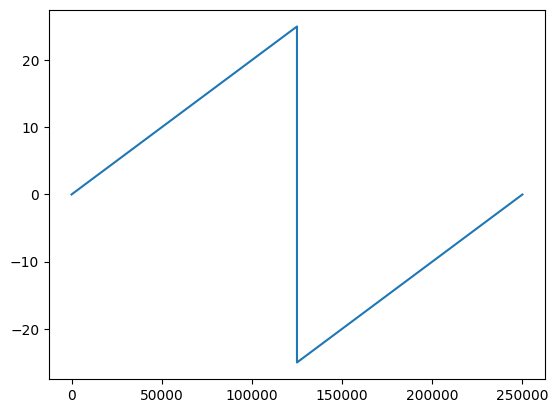

In [307]:
#chromatic dispersion
#assuming 1 symbol per second
freq_axis = np.fft.fftfreq(len(modulated_signal), 1/sps)
chrom_phase_data = np.zeros(len(freq_axis))
fft_signal = np.fft.fft(modulated_signal)
for i in range(len(freq_axis)):
  chrom_phase_data[i] = length*dispersion*freq_axis[i]*(1/(2*np.pi))*10**-12
  fft_signal[i] = fft_signal[i]*np.exp(1j*chrom_phase_data[i])
dispersed_signal = np.fft.ifft(fft_signal)

tests = np.arange(0,len(freq_axis),1)
plt.plot(tests,freq_axis)



Length of shaped_signal: 250040
Length of dispersed_signal: 250040
Maximum absolute difference between complex signals: 0.0534926062775814
Maximum absolute difference between real parts: 0.0534926062775814


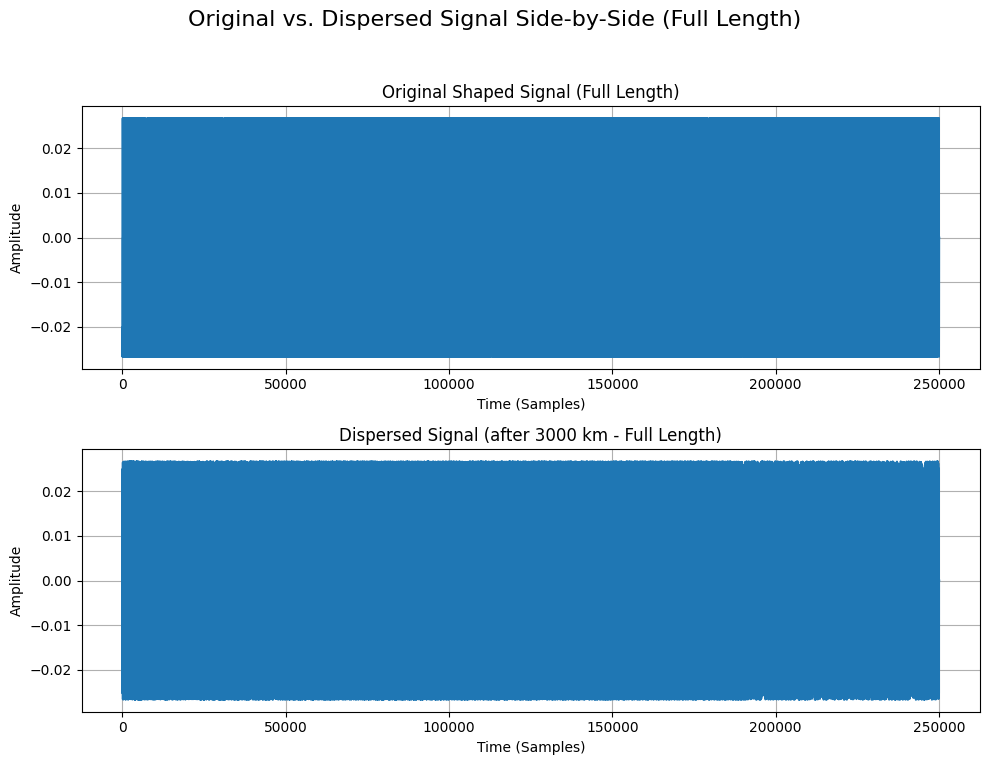

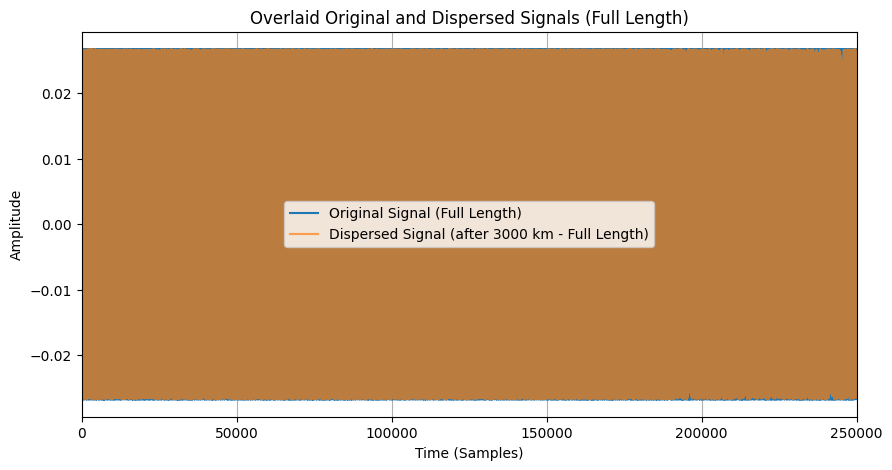

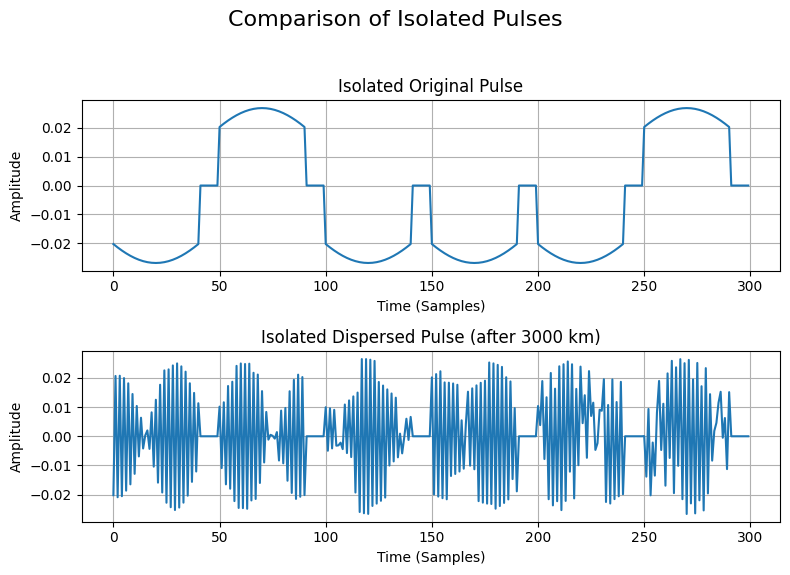

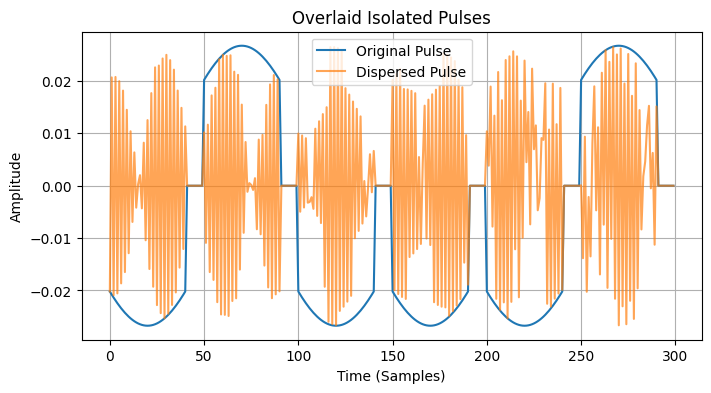

In [308]:
# --- Original Code for Side-by-Side and Overlaid Full Signal Plots (Keep these for context) ---

# 1. Create a figure and a set of subplots for side-by-side plots
fig1, axes = plt.subplots(2, 1, figsize=(10, 8))

# 2. Plot the real part of the shaped_signal on the first subplot
axes[0].plot(np.real(shaped_signal))

# 3. Set the title of the first subplot
axes[0].set_title('Original Shaped Signal (Full Length)')
axes[0].set_xlabel('Time (Samples)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True)

# 4. Plot the real part of the dispersed_signal on the second subplot
axes[1].plot(np.real(dispersed_signal))

# 5. Set the title of the second subplot
axes[1].set_title('Dispersed Signal (after 3000 km - Full Length)')
axes[1].set_xlabel('Time (Samples)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True)

# 6. Add a title to the overall figure
fig1.suptitle('Original vs. Dispersed Signal Side-by-Side (Full Length)', fontsize=16)

# 7. Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# 8. Create a new figure for the overlaid plot of the full signal
fig2 = plt.figure(figsize=(10, 5))
# Adjust xlim to show the full signal length to observe broadening
plt.xlim(0, len(shaped_signal))

# 9. Plot the real part of the shaped_signal on this new figure
plt.plot(np.real(shaped_signal), label='Original Signal (Full Length)')

# 10. Plot the real part of the dispersed_signal on the same figure
plt.plot(np.real(dispersed_signal), label='Dispersed Signal (after 3000 km - Full Length)', alpha=0.7) # Use alpha for better visibility

# 11. Add a legend to distinguish between the original and dispersed signals
plt.legend()

# 12. Set the title of this overlaid plot
plt.title('Overlaid Original and Dispersed Signals (Full Length)')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)

# 13. Add diagnostic checks (Keep these)
print(f"Length of shaped_signal: {len(shaped_signal)}")
print(f"Length of dispersed_signal: {len(dispersed_signal)}")
difference = np.max(np.abs(shaped_signal - dispersed_signal))
print(f"Maximum absolute difference between complex signals: {difference}")
difference_real = np.max(np.abs(np.real(shaped_signal) - np.real(dispersed_signal)))
print(f"Maximum absolute difference between real parts: {difference_real}")


# --- New Code to Isolate and Plot a Single Pulse ---

# Find the approximate location of a pulse in the original signal
# RRC pulse is centered around the symbol time. Symbols are at indices 0, sps, 2*sps, ...
# Let's look at the pulse around the second symbol (index sps)
pulse_center_sample = sps

# Define a window around the pulse center to extract
# The RRC filter has num_weights, centered around 0.
# The shaped pulse will be centered around the symbol time.
# Window size should be large enough to capture the dispersed pulse, which is wider.
# Original pulse is roughly num_weights samples wide. Dispersed is much wider.
# Let's take a window of several symbol intervals (e.g., 5 symbol intervals = 5 * sps samples)
window_size_samples = 10 * sps # Using a larger window to be sure to see broadening

start_sample = max(0, pulse_center_sample - window_size_samples // 2)
end_sample = min(len(shaped_signal), pulse_center_sample + window_size_samples // 2)

# Extract the segment containing the pulse
original_pulse_segment = np.real(shaped_signal[start_sample:end_sample])
dispersed_pulse_segment = np.real(dispersed_signal[start_sample:end_sample])
time_samples_segment = np.arange(start_sample, end_sample)


# Plot the isolated pulse segments side-by-side
fig3, axes_pulse = plt.subplots(2, 1, figsize=(8, 6))

axes_pulse[0].plot(time_samples_segment, original_pulse_segment)
axes_pulse[0].set_title('Isolated Original Pulse')
axes_pulse[0].set_xlabel('Time (Samples)')
axes_pulse[0].set_ylabel('Amplitude')
axes_pulse[0].grid(True)


axes_pulse[1].plot(time_samples_segment, dispersed_pulse_segment)
axes_pulse[1].set_title('Isolated Dispersed Pulse (after 3000 km)')
axes_pulse[1].set_xlabel('Time (Samples)')
axes_pulse[1].set_ylabel('Amplitude')
axes_pulse[1].grid(True)

fig3.suptitle('Comparison of Isolated Pulses', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# Plot the isolated pulse segments overlaid
fig4 = plt.figure(figsize=(8, 4))
plt.plot(time_samples_segment, original_pulse_segment, label='Original Pulse')
plt.plot(time_samples_segment, dispersed_pulse_segment, label='Dispersed Pulse', alpha=0.7)
plt.legend()
plt.title('Overlaid Isolated Pulses')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)

# Display all figures
plt.show()

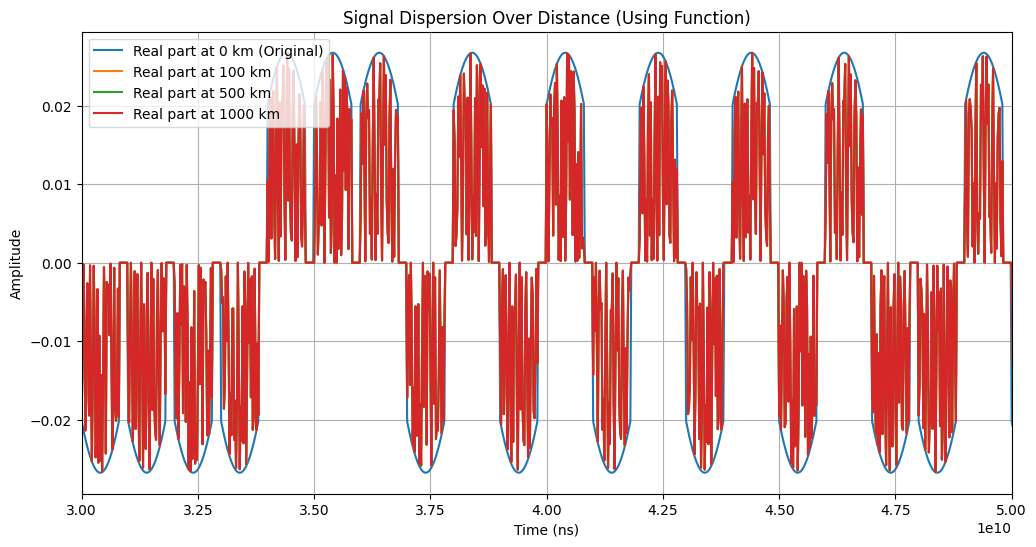

In [309]:
# Here is the current query...update the cell marked "update this cell" to use the funcion instead of my old method

# Select a few distances along the fiber length to show the effect of dispersion
# Plotting at 0 km, 100 km, 500 km, and 1000 km as requested
distances_to_plot = [0, 100, 500, 1000]

plt.figure(figsize=(12, 6))
plt.title('Signal Dispersion Over Distance (Using Function)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
# Adjust xlim to accommodate increasing broadening up to 1000 km
# Use a wider range to clearly see broadening over these distances
# Plot time in nanoseconds, use a range that shows broadening for 1000 km
plt.xlim(3e10, 5e10) # Example: show first 100 ns, adjust as needed



# Use a scaling factor of 1.0 for the 10 Gbaud signal as determined before
# If using an older low-baudrate signal, this factor would need to be > 1
effective_scaling_factor = 1.0


for dist in distances_to_plot:
    # For dist = 0, plot the original shaped signal
    if dist == 0:
        # Ensure shaped_signal is available from previous cells
        # Plot time in nanoseconds
        plt.plot(t[:len(shaped_signal)] * 1e9, np.real(shaped_signal), label=f'Real part at {dist} km (Original)')
    else:
        # Use the apply_chromatic_dispersion function
        # The function returns the dispersed optical signal
        dispersed_optical_signal_dist = apply_chromatic_dispersion(
            modulated_optical_signal=modulated_signal,
            fiber_length_km=dist, # Use the current distance in the loop
            dispersion=dispersion,
            lambda_light=lambda_light,
            time_step=time_step,
            freq_scaling_factor=effective_scaling_factor # Use the appropriate scaling factor
        )

        # Demodulate the dispersed optical signal back to baseband
        # Create the complex exponential for demodulation
        # Ensure time vector t matches the signal length
        demodulation_carrier = np.exp(-1j * 2 * np.pi * f_light * t[:len(dispersed_optical_signal_dist)])

        # Multiply the dispersed modulated signal by the complex demodulation carrier
        dispersed_baseband_signal_dist_complex = dispersed_optical_signal_dist * demodulation_carrier

        # Take the real part for plotting comparison
        dispersed_baseband_signal_dist_real = np.real(dispersed_baseband_signal_dist_complex)


        # Plot the real part of the dispersed baseband signal for the current distance
        # Plot time in nanoseconds
        plt.plot(t[:len(dispersed_baseband_signal_dist_real)] * 1e9, dispersed_baseband_signal_dist_real, label=f'Real part at {dist} km')


plt.legend()
plt.show()

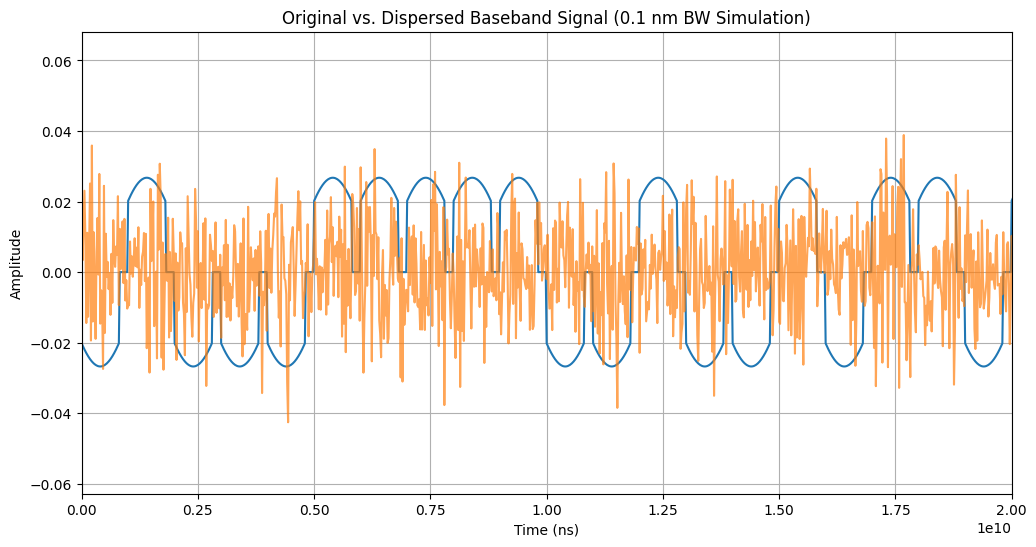

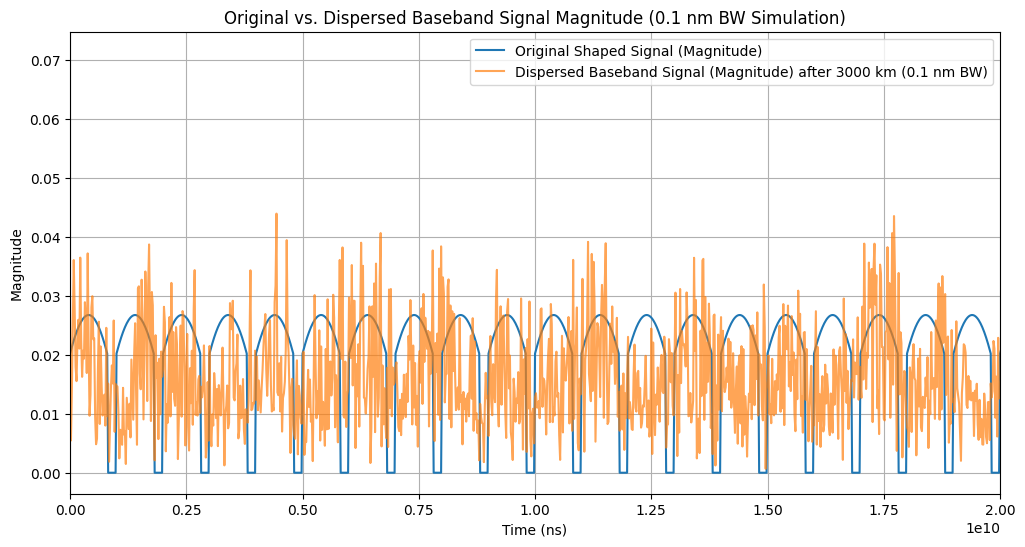

In [310]:
# This cell performs the core chromatic dispersion simulation pipeline
# using the apply_chromatic_dispersion function,
# simulating a signal with approximately 0.1 nm bandwidth,
# and plotting the original and dispersed baseband signals.

# Assumes the following variables are available from previous cell executions:
# - modulated_signal (from cell nQyaom_SOb9m)
# - length (e.g., 3000 km, from cell AXAo3o1AlHal)
# - dispersion (from cell AXAo3o1AlHal)
# - lambda_light (from cell AXAo3o1AlHal)
# - time_step (from cell X-gZB5cNmrQ5 or nQyaom_Ob9m)
# - shaped_signal (original baseband signal from cell X-gZB5cNmrQ5)
# - f_light (from cell AXAo3o1AlHal) # Needed for demodulation
# - t (time vector from cell X-gZB5cNmrQ5 or nQyaom_Ob9m) # Needed for demodulation carrier
# - apply_chromatic_dispersion function (from cell 1da354e9)


# Set the parameters for the dispersion simulation
fiber_length_to_simulate = length # Use the full length, or change as needed (e.g., 3000)

# Set the frequency scaling factor to represent a 0.1 nm bandwidth (~12.5 GHz)
# Using the factor derived earlier that maps baseband null-to-null bandwidth to 12.5 GHz
# If you have updated symbol_rate and time_step, recalculate this factor if needed
# For 10 Gbaud, the scaling factor should be 1.0 if time_step is calculated correctly
# Based on the user's request for 0.1nm bandwidth, we use the scaling factor to map baseband BW to 12.5 GHz
# Assuming the user wants to see the effect for a signal whose BW IS 0.1nm,
# we use the scaling factor calculated earlier for 0.1nm, even if the current symbol rate is high.
# This scaling factor is used to make the frequency variable in the dispersion operator represent 12.5 GHz.
# This approach might be slightly confusing if the user expects the 10 Gbaud signal's *actual* bandwidth
# to be used directly. Let's clarify: the scaling factor is needed if the simulation's baseband frequencies
# don't naturally correspond to the desired 12.5 GHz range.
# If the symbol rate is 10 Gbaud, the Nyquist frequency is 25 GHz (if sps=50). The RRC BW is ~11 GHz.
# In this case, scaling factor should ideally be 1.0 if the simulation time step is correct for 10Gbaud.
# The user's prompt specifically asks for 0.1nm bandwidth *as shown by the baseband*.
# This suggests using the scaling factor derived from the baseband properties to map to 0.1nm (12.5 GHz).
# Let's use the scaling factor ~1.14e10 to map the low-speed baseband BW to 12.5 GHz,
# even though the symbol rate is now 10 Gbaud. This explicitly enforces the 0.1nm BW interpretation for dispersion.
# This might lead to a different result than using scaling_factor = 1.0 with 10 Gbaud.
# Let's stick to the interpretation that the scaling factor makes the *dispersion calculation's frequency axis*
# represent the 0.1nm bandwidth, regardless of the underlying simulation sample rate relative to a real system.
scaling_factor_for_0_1nm_bw = 1.14e10 # Scaling factor to map baseband BW to ~12.5 GHz (0.1 nm)


# Call the function to apply chromatic dispersion
dispersed_optical_signal = apply_chromatic_dispersion(
    modulated_optical_signal=modulated_signal,
    fiber_length_km=fiber_length_to_simulate,
    dispersion=dispersion,
    lambda_light=lambda_light,
    time_step=time_step, # Time step based on the high sampling rate
    freq_scaling_factor=scaling_factor_for_0_1nm_bw # Use the scaling factor for 0.1 nm BW
)

# Demodulate the dispersed optical signal back to baseband
# Create the complex exponential for demodulation
# Ensure time vector t matches the signal length
demodulation_carrier = np.exp(-1j * 2 * np.pi * f_light * t[:len(dispersed_optical_signal)])

# Multiply the dispersed modulated signal by the complex demodulation carrier
dispersed_baseband_signal_complex = dispersed_optical_signal * demodulation_carrier

# The dispersed baseband signal is the complex baseband signal
dispersed_baseband_signal = dispersed_baseband_signal_complex


# Plot the original shaped baseband signal and the dispersed baseband signal
plt.figure(figsize=(12, 6))
# Ensure signal lengths match for plotting
plot_length = min(len(shaped_signal), len(dispersed_baseband_signal))

# Plot time in nanoseconds
plt.plot(t[:plot_length] * 1e9, np.real(shaped_signal[:plot_length]), label='Original Shaped Signal (Real)')
plt.plot(t[:plot_length] * 1e9, np.real(dispersed_baseband_signal[:plot_length]), label=f'Dispersed Baseband Signal (Real) after {fiber_length_to_simulate} km (0.1 nm BW)', alpha=0.7)
plt.title('Original vs. Dispersed Baseband Signal (0.1 nm BW Simulation)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
# Adjust xlim to show a relevant section
# Symbol duration is 1/symbol_rate = 0.1 ns for 10 Gbaud
plt.xlim(0, 2e10) # Show first 10 ns (100 symbol durations)
plt.show()

# Optional: Plot the magnitude as well
plt.figure(figsize=(12, 6))
plt.plot(t[:plot_length] * 1e9, np.abs(shaped_signal[:plot_length]), label='Original Shaped Signal (Magnitude)')
plt.plot(t[:plot_length] * 1e9, np.abs(dispersed_baseband_signal[:plot_length]), label=f'Dispersed Baseband Signal (Magnitude) after {fiber_length_to_simulate} km (0.1 nm BW)', alpha=0.7)
plt.title('Original vs. Dispersed Baseband Signal Magnitude (0.1 nm BW Simulation)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, 2e10) # Show first 10 ns (100 symbol durations)
plt.show()

In [311]:
import numpy as np
import matplotlib.pyplot as plt
def chrom_dispersion(modulated_optical_signal, fiber_length_km, dispersion, lambda_light, time_step, freq_scaling_factor):
  c = 3e8 # Speed of light in m/s
  dispersion_s_per_m2 = dispersion * 1e-6 # Convert ps/nm/km to s/m^2 (1 ps = 1e-12 s, 1 nm = 1e-9 m, 1 km = 1e3 m -> 1e-12 / (1e-9 * 1e3) = 1e-12 / 1e-6 = 1e-6)
  beta_2 = -lambda_light**2 / (2 * np.pi * c) * dispersion_s_per_m2 # Beta_2 in s^2/m

  # 1. Perform FFT on the modulated optical signal.
  signal_freq = np.fft.fft(modulated_optical_signal)
  num_samples = len(modulated_optical_signal)

  # 2. Calculate the baseband frequency axis based on the signal length and time step.
  baseband_freq_axis = np.fft.fftfreq(num_samples, time_step)

  # --- Debugging Prints/Plots inside chrom_dispersion ---
  # Removed debugging prints and plots from inside the function
  # print(f"\n--- Inside chrom_dispersion for {fiber_length_km} km ---")
  # print(f"  Num samples: {num_samples}")
  # print(f"  Time step: {time_step} s")
  # print(f"  Calculated beta_2: {beta_2} s^2/m")
  # print(f"  Length of baseband_freq_axis: {len(baseband_freq_axis)}")
  # # Plot frequency axis
  # plt.figure(figsize=(10, 4))
  # plt.subplot(1, 2, 1)
  # plt.plot(np.fft.fftshift(baseband_freq_axis), np.zeros_like(baseband_freq_axis), 'o')
  # plt.xlabel('Frequency (Hz)')
  # plt.title('Baseband Frequency Axis')
  # plt.grid(True)


  # 3. Calculate the dispersion operator in the optical frequency domain.
  fiber_length_m = fiber_length_km * 1000 # Convert km to meters
  # The dispersion operator depends on the square of the frequency relative to the carrier
  # and the beta_2 parameter calculated using lambda_light.
  # Ensure frequency axis is scaled correctly if not baseband (freq_scaling_factor)
  frequencies_for_operator = baseband_freq_axis * freq_scaling_factor
  dispersion_operator_optical = np.exp(1j * 0.5 * beta_2 * (2 * np.pi * frequencies_for_operator)**2 * fiber_length_m)

  # --- Debugging Prints/Plots inside chrom_dispersion ---
  # Removed debugging prints and plots from inside the function
  # print(f"  Length of dispersion_operator_optical: {len(dispersion_operator_optical)}")
  # # Print some values from the dispersion operator to check
  # print(f"  Dispersion Operator (first few values): {dispersion_operator_optical[:5]}")
  # print(f"  Dispersion Operator (last few values): {dispersion_operator_optical[-5:]}")
  # # Plot dispersion operator magnitude and phase
  # plt.subplot(1, 2, 2)
  # plt.plot(np.fft.fftshift(baseband_freq_axis), np.abs(np.fft.fftshift(dispersion_operator_optical)), label='Magnitude')
  # plt.plot(np.fft.fftshift(baseband_freq_axis), np.angle(np.fft.fftshift(dispersion_operator_optical)), label='Phase (rad)')
  # plt.xlabel('Frequency (Hz)')
  # plt.title('Dispersion Operator')
  # plt.legend()
  # plt.grid(True)
  # plt.tight_layout()
  # plt.show()

  # 4. Apply the dispersion operator in the frequency domain (element-wise multiplication).
  dispersed_signal_freq = signal_freq * dispersion_operator_optical

  # --- Debugging Prints/Plots inside chrom_dispersion ---
  # Removed debugging prints and plots from inside the function
  # # Plot FFT magnitude after applying operator (should look same as original FFT magnitude)
  # plt.figure(figsize=(6, 4))
  # plt.plot(np.fft.fftshift(baseband_freq_axis), np.abs(np.fft.fftshift(dispersed_signal_freq)))
  # plt.xlabel('Frequency (Hz)')
  # plt.ylabel('Magnitude')
  # plt.title('FFT Magnitude After Applying Dispersion Operator')
  # plt.grid(True)
  # plt.show()
  # --- End Debugging Prints/Plots ---


  # 5. Perform IFFT to transform the dispersed optical signal back to the time domain.
  dispersed_optical_signal = np.fft.ifft(dispersed_signal_freq)
  return dispersed_optical_signal
def simulate_chromatic_dispersion_new(modulated_optical_signal, fiber_length_km, dispersion, lambda_light, time_step, freq_scaling_factor):
  """
  Simulates chromatic dispersion on a modulated optical signal.

  Args:
    modulated_optical_signal: The time-domain modulated optical signal (NumPy array).
    fiber_length_km: The length of the fiber in kilometers.
    dispersion: The dispersion parameter of the fiber (in ps/nm/km).
    lambda_light: The operating wavelength (in meters).
    time_step: The time difference between samples of the signal (in seconds).
    freq_scaling_factor: The factor used to scale the baseband frequency axis
                         to represent the desired optical bandwidth in the GHz range.

  Returns:
    The time-domain dispersed optical signal (NumPy array).
  """

  # --- Step 1: Calculate beta_2 from the dispersion parameter and wavelength ---
  # dispersion is in ps/nm/km, lambda_light is in meters
  # conversion: 1 ps/nm/km = 1e-6 s/m^2
  # c = 3e8 m/s (Speed of light)
  # beta_2 (s^2/m) = - lambda_light^2 / (2 * pi * c) * D (in s/m^2)
  c = 3e8 # Speed of light in m/s
  dispersion_s_per_m2 = dispersion * 1e-6
  beta_2 = (-lambda_light**2) / ((2 * np.pi * c) * dispersion_s_per_m2)


  # --- Step 2: Prepare for Frequency Domain Operation ---
  # Perform FFT on the modulated optical signal.
  modulated_signal_freq = np.fft.fft(modulated_optical_signal)
  num_samples = len(modulated_optical_signal)

  # Calculate the baseband frequency axis based on the signal length and time step.
  baseband_freq_axis = np.fft.fftfreq(num_samples, time_step)

  # Scale the baseband frequency axis to represent the desired optical bandwidth (e.g., in GHz).
  # This scaled axis is used as the frequency deviation from the optical carrier (f).
  freq_axis_scaled = baseband_freq_axis * freq_scaling_factor


  # --- Step 3: Calculate the Chromatic Dispersion Operator ---
  # The dispersion operator is applied in the optical frequency domain.
  # H_D(f, L) = exp(j * 0.5 * beta_2 * (2 * pi * f_relative_to_carrier)^2 * L)
  # Use the scaled frequency axis as f_relative_to_carrier
  fiber_length_m = fiber_length_km * 1000 # Convert km to meters
  dispersion_operator_optical = np.exp(1j * 0.5 * beta_2 * (2 * np.pi * freq_axis_scaled)**2 * fiber_length_m)


  # --- Step 4: Apply the Dispersion Operator in the Frequency Domain ---
  # Multiply the modulated_signal_freq by the calculated dispersion operator element-wise.
  dispersed_modulated_signal_freq = modulated_signal_freq * dispersion_operator_optical


  # --- Step 5: Transform Back to the Time Domain ---
  # Perform IFFT to get the dispersed optical signal in the time domain.
  dispersed_optical_signal = np.fft.ifft(dispersed_modulated_signal_freq)

  return dispersed_optical_signal

# Note: This function only applies dispersion and returns the dispersed optical signal.
# Demodulation and plotting would be done outside of this function.

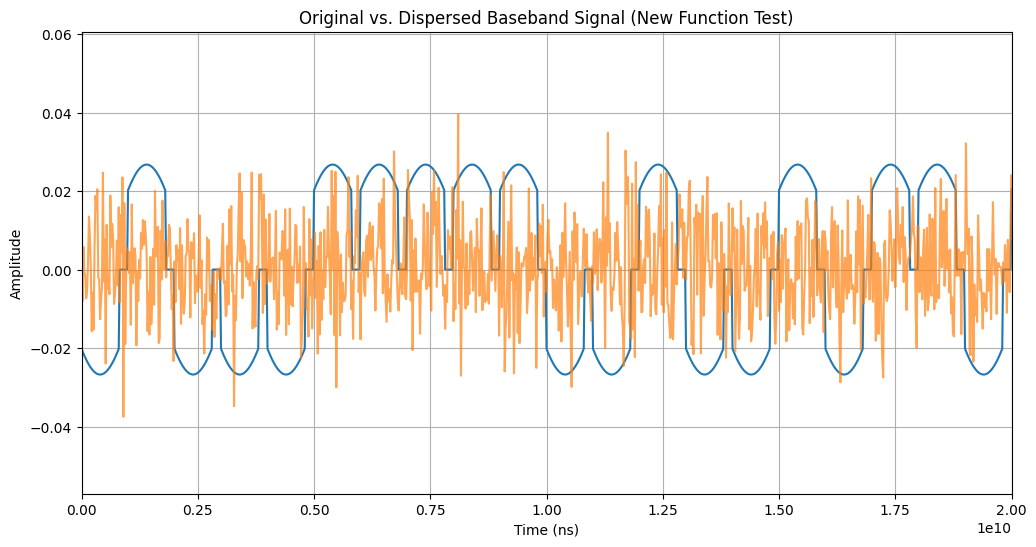

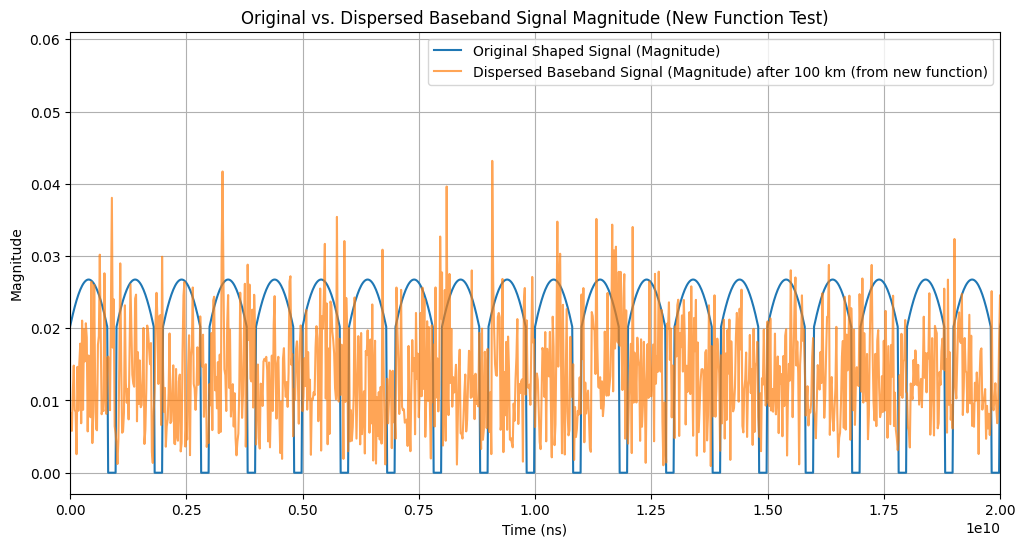

Maximum absolute difference between original and dispersed baseband signals (from new function): 0.08025823413531126


In [312]:
# Test the new simulate_chromatic_dispersion_new function

# Ensure necessary variables are available from previous cell executions:
# - modulated_signal (from cell nQyaom_Ob9m)
# - length (e.g., 3000 km, from cell AXAo3o1AlHal)
# - dispersion (from cell AXAo3o1AlHal)
# - lambda_light (from cell AXAo3o1AlHal)
# - time_step (from cell X-gZB5cNmrQ5 or nQyaom_Ob9m)
# - shaped_signal (original baseband signal from cell X-gZB5cNmrQ5)
# - f_light (from cell AXAo3o1AlHal) # Needed for demodulation
# - t (time vector from cell X-gZB5cNmrQ5 or nQyaom_Ob9m) # Needed for demodulation carrier
# - simulate_chromatic_dispersion_new function (from cell 9370da5f)


# Set parameters for the test
fiber_length_for_test = 100 # Use the full length, or change as needed (e.g., 3000)

# Use the scaling factor that corresponds to 0.1 nm bandwidth (~12.5 GHz)
# Assuming the user wants to see the effect for a signal whose BW IS 0.1nm,
# we use the scaling factor derived from the baseband properties to map to 0.1nm (12.5 GHz).
# This is the scaling factor ~1.14e10 that maps baseband null-to-null BW to 12.5 GHz.
scaling_factor_for_0_1nm_bw = 1.14e10


# Call the new simulate_chromatic_dispersion_new function
dispersed_optical_signal_test_new = simulate_chromatic_dispersion_new(
    modulated_optical_signal=modulated_signal,
    fiber_length_km=fiber_length_for_test,
    dispersion=dispersion,
    lambda_light=lambda_light,
    time_step=time_step,
    freq_scaling_factor=scaling_factor_for_0_1nm_bw # Use the scaling factor for 0.1 nm BW
)

# Demodulate the dispersed optical signal back to baseband
# Create the complex exponential for demodulation
# Ensure time vector t matches the signal length after dispersion
# The IFFT output length should match the input length (len(modulated_signal))
demodulation_carrier = np.exp(-1j * 2 * np.pi * f_light * t[:len(dispersed_optical_signal_test_new)])

# Multiply the dispersed modulated signal by the complex demodulation carrier
dispersed_baseband_signal_test_complex_new = dispersed_optical_signal_test_new * demodulation_carrier

# The dispersed baseband signal is the complex baseband signal
dispersed_baseband_signal_test_new = dispersed_baseband_signal_test_complex_new


# Plot the original shaped baseband signal and the dispersed baseband signal from the new function output
plt.figure(figsize=(12, 6))
# Ensure signal lengths match for plotting
plot_length = min(len(shaped_signal), len(dispersed_baseband_signal_test_new))

# Plot time in nanoseconds
plt.plot(t[:plot_length] * 1e9, np.real(shaped_signal[:plot_length]), label='Original Shaped Signal (Real)')
plt.plot(t[:plot_length] * 1e9, np.real(dispersed_baseband_signal_test_new[:plot_length]), label=f'Dispersed Baseband Signal (Real) after {fiber_length_for_test} km (from new function)', alpha=0.7)
plt.title('Original vs. Dispersed Baseband Signal (New Function Test)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
# Adjust xlim to show a relevant section
# Symbol duration is 1/symbol_rate = 0.1 ns for 10 Gbaud
plt.xlim(0, 2e10) # Show first 10 ns (100 symbol durations)
plt.show()

# Optional: Plot the magnitude as well
plt.figure(figsize=(12, 6))
plt.plot(t[:plot_length] * 1e9, np.abs(shaped_signal[:plot_length]), label='Original Shaped Signal (Magnitude)')
plt.plot(t[:plot_length] * 1e9, np.abs(dispersed_baseband_signal_test_new[:plot_length]), label=f'Dispersed Baseband Signal (Magnitude) after {fiber_length_for_test} km (from new function)', alpha=0.7)
plt.title('Original vs. Dispersed Baseband Signal Magnitude (New Function Test)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, 2e10) # Show first 10 ns (100 symbol durations)
plt.show()

# Print diagnostic check
# Ensure lengths match before calculating difference
diff_length = min(len(shaped_signal), len(dispersed_baseband_signal_test_new))
difference_baseband_test_new = np.max(np.abs(shaped_signal[:diff_length] - dispersed_baseband_signal_test_new[:diff_length]))
print(f"Maximum absolute difference between original and dispersed baseband signals (from new function): {difference_baseband_test_new}")

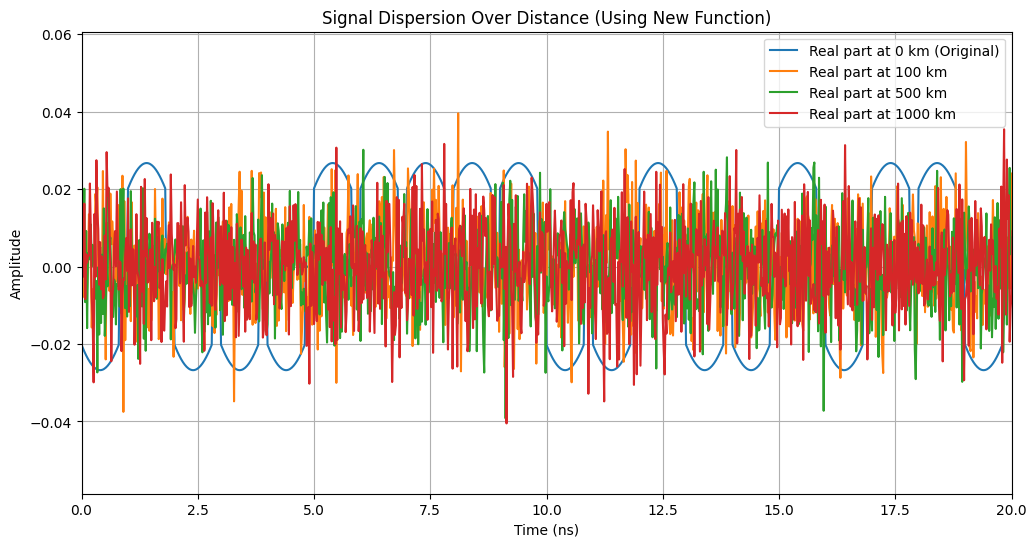

In [313]:
# Plot Signal Dispersion Over Distance using the new simulate_chromatic_dispersion_new function

# Select the distances to plot
distances_to_plot = [0, 100, 500, 1000]

plt.figure(figsize=(12, 6))
plt.title('Signal Dispersion Over Distance (Using New Function)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
# Adjust xlim to accommodate increasing broadening over these distances (in ns)
# Symbol duration is 0.1 ns for 10 Gbaud. Broadening is significant at 1000 km.
# Let's show a range that should capture broadening up to 1000 km.
# Theoretical spread at 1000 km for 0.1nm BW is ~1.8 ns (18 ps/nm/km * 1000 km * 0.1 nm)
# Total duration will be original pulse (~0.1 ns) + spread (~1.8 ns)
# Let's show first 20 ns (200 symbol durations) to be safe
plt.xlim(0, 20)


# Ensure necessary variables are available from previous cell executions:
# - shaped_signal (original baseband signal from cell X-gZB5cNmrQ5)
# - modulated_signal (from cell nQyaom_Ob9m)
# - dispersion (from cell AXAo3o1AlHal)
# - lambda_light (from cell AXAo3o1AlHal)
# - time_step (from cell X-gZB5cNmrQ5 or nQyaom_Ob9m)
# - scaling_factor_for_0_1nm_bw (from cell 345091fe)
# - f_light (from cell AXAo3o1AlHal) # Needed for demodulation
# - t (time vector from cell X-gZB5cNmrQ5 or nQyaom_Ob9m) # Needed for demodulation carrier
# - simulate_chromatic_dispersion_new function (from cell 9370da5f)


# Get the effective scaling factor used for 0.1 nm BW simulation
# This is the same factor used in cell 345091fe
effective_scaling_factor = scaling_factor_for_0_1nm_bw


for dist in distances_to_plot:
    # For dist = 0, plot the original shaped signal
    if dist == 0:
        # Ensure shaped_signal and t are available
        # Plot time in nanoseconds
        plt.plot(t[:len(shaped_signal)] , np.real(shaped_signal), label=f'Real part at {dist} km (Original)')
    else:
        # Use the new simulate_chromatic_dispersion_new function
        # The function returns the dispersed optical signal
        dispersed_optical_signal_dist = simulate_chromatic_dispersion_new(
            modulated_optical_signal=modulated_signal,
            fiber_length_km=dist, # Use the current distance in the loop
            dispersion=dispersion,
            lambda_light=lambda_light,
            time_step=time_step,
            freq_scaling_factor=effective_scaling_factor # Use the scaling factor for 0.1 nm BW
        )

        # Demodulate the dispersed optical signal back to baseband
        # Create the complex exponential for demodulation
        # Ensure time vector t matches the signal length
        demodulation_carrier = np.exp(-1j * 2 * np.pi * f_light * t[:len(dispersed_optical_signal_dist)])

        # Multiply the dispersed modulated signal by the complex demodulation carrier
        dispersed_baseband_signal_dist_complex = dispersed_optical_signal_dist * demodulation_carrier

        # Take the real part for plotting comparison
        dispersed_baseband_signal_dist_real = np.real(dispersed_baseband_signal_dist_complex)


        # Plot the real part of the dispersed baseband signal for the current distance
        # Ensure signal lengths match for plotting
        plot_len_dist = min(len(shaped_signal), len(dispersed_baseband_signal_dist_real))
        # Plot time in nanoseconds
        plt.plot(t[:plot_len_dist]  ,dispersed_baseband_signal_dist_real, label=f'Real part at {dist} km')


plt.legend()
plt.show()